In [4]:
!pip install sklearn
!pip install numpy

Looking in indexes: http://mirrors.aliyun.com/pypi/simple
Looking in indexes: http://mirrors.aliyun.com/pypi/simple


In [1]:
import torch
import csv
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from PIL import Image, ImageFile
import torchvision.transforms as transforms
from torchvision import models
import torch.utils.model_zoo as model_zoo
import torch.nn.functional as F
import torch.optim as optim
import os
import json
from transformers import BertTokenizer, BertModel
from transformers import XLNetModel, XLNetTokenizerFast
import operator
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import manifold, datasets
from sklearn.cluster import KMeans

2022-05-22 21:24:16.468956: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
import torch
torch.cuda.empty_cache()
torch.cuda.memory_summary(device=None, abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |       0 B  |       0 B  |       0 B  |       0 B  |\n|       from large pool |       0 B  |       0 B  |       0 B  |       0 B  |\n|       from small pool |       0 B  |       0 B  |       0 B  |       0 B  |\n|---------------------------------------------------------------------------|\n| Active memory         |       0 B  |       0 B  |       0 B  |       0 B  |\n|       from large pool |       0 B  |       0 B  |

In [3]:
device = torch.device('cuda')
tokenizer = XLNetTokenizerFast.from_pretrained("xlnet-base-cased")
pre_trained_model = XLNetModel.from_pretrained("xlnet-base-cased")

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetModel: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [4]:
from transformers import AutoModel, AutoTokenizer
device = torch.device('cuda')
# Import our models. The package will take care of downloading the models automatically
tokenizer = AutoTokenizer.from_pretrained("princeton-nlp/sup-simcse-bert-base-uncased")
pre_trained_model = AutoModel.from_pretrained("princeton-nlp/sup-simcse-bert-base-uncased")

In [5]:
class BERTEncoder(nn.Module):
    def __init__(self, bert, tokenizer,code_length,device):
        super(BERTEncoder, self).__init__()
        self.device = device
        self.tokenizer = tokenizer
        self.encoder = bert.to(device)
        self.code_length = code_length

    def forward(self, inputs):
        tokens_X, segments_X, masks = inputs[:,0],inputs[:,1],inputs[:,2]
        with torch.no_grad():
            encoded_X = self.encoder(tokens_X, token_type_ids=segments_X, attention_mask=masks).last_hidden_state
        return encoded_X[:,0]
        
    def encode(self,context):
        after_encode = tokenizer(context,max_length=self.code_length,padding="max_length")
        inputs = torch.stack([torch.stack([torch.tensor(after_encode['input_ids'][:512]),torch.tensor(after_encode['token_type_ids'][:512]),torch.tensor(after_encode['attention_mask'][:512])])]).to(device)
        outputs = torch.Tensor.cpu(self.forward(inputs))
        return outputs

In [6]:
class ContextVector:
    def __init__(self,context,title,tag,vector):
        self.vector = vector
        self.context = context
        self.title = title
        self.tag = tag
def VectorEncode(load_path,encoder):
    with open(load_path) as json_data:
        dev = json.load(json_data)
    context_vectors = []
    count = 0
    for data in dev['data']:
        title = data['title']
        print(title)
        tag = data['Tag']
        count += 1
        if tag == 'HisGeo':
            label = 0
        elif tag == 'ArtLang':
            label = 1
        elif tag == 'TechSci':
            label = 2
        elif tag == 'IntroBio':
            label = 3
        for paragraphs in data['paragraphs']:
            context = paragraphs['context']
            with torch.no_grad():
                vector = encoder.encode(context)
            # context_vectors.append(ContextVector(context,title,tag,vector))
            context_vectors.append([count,label,vector])
    return context_vectors

In [7]:
encoder = BERTEncoder(pre_trained_model,tokenizer,512,device)

In [8]:
vecs = VectorEncode('test_big_with_tag.json',encoder)
#vecs = VectorEncode('train-v2.0-Tag1.0.json',encoder)

Beyoncé
Frédéric_Chopin
Sino-Tibetan_relations_during_the_Ming_dynasty
IPod
The_Legend_of_Zelda:_Twilight_Princess
Spectre_(2015_film)
2008_Sichuan_earthquake
New_York_City


In [9]:
Y = []
X = []
for _,y,x in vecs:
    X.append(torch.Tensor.cpu(x[0]).numpy())
    Y.append(y)
X = np.array(X)

/root/miniconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/root/miniconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


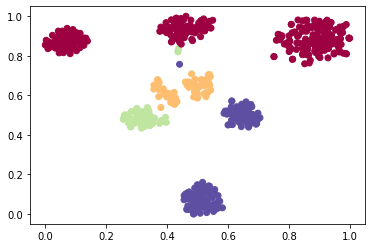

In [10]:
'''t-SNE'''
tsne = manifold.TSNE(n_components=2, init='pca', random_state=501)
X_tsne = tsne.fit_transform(X)


'''嵌入空间可视化'''
x_min, x_max = X_tsne.min(0), X_tsne.max(0)
X_norm = (X_tsne - x_min) / (x_max - x_min)  # 归一化
#plt.figure(figsize=(8, 8))
#for i in range(X_norm.shape[0]):
#    plt.text(X_norm[i, 0], X_norm[i, 1], str(Y[i]), color=plt.cm.Set1(Y[i]), 
#             fontdict={'weight': 'bold', 'size': 9})
#plt.xticks([])
#plt.yticks([])
#plt.show()

plt.scatter(X_norm[:, 0], X_norm[:, 1], c=Y, cmap=plt.cm.Spectral)
#ax.xaxis.set_major_formatter(NullFormatter())  # 设置标签显示格式为空
#ax.yaxis.set_major_formatter(NullFormatter())

In [11]:
res = {}
vectors = []
for count,tag,vector in vecs:
    data = {}
    data['count'] = count
    data['tag'] = tag
    data['vector'] = vector.tolist()
    vectors.append(data)
res['vecs'] = vectors
with open("vecs.json","w") as os:
        json.dump(res,os)

In [22]:
res = {}
res['X_norm'] = X_norm.tolist()
with open("xnormXL3.json","w") as os:
        json.dump(res,os)

In [18]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(X)

In [38]:
kmeans.labels_

array([1, 1, 1, ..., 0, 0, 0], dtype=int32)

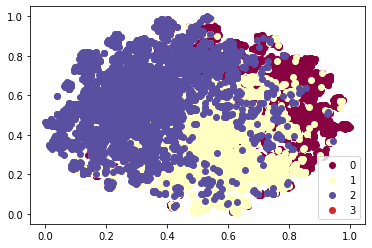

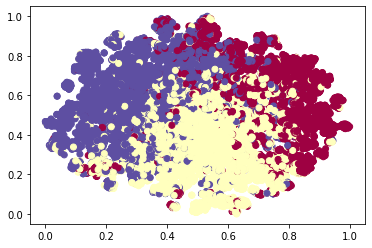

In [41]:
fig,ax = plt.subplots()
colors = ['#880141','#FFFFC1','#5A4FA0','tab:red']
for color in range(4):
    x = X_norm[kmeans.labels_==color,0]
    y = X_norm[kmeans.labels_==color,1]
    ax.scatter(x,y,c=colors[color],label=color)

ax.legend()
#plt.scatter(X_norm[:, 0], X_norm[:, 1], c=kmeans.labels_, cmap=plt.cm.Spectral)
plt.show()


plt.scatter(X_norm[:, 0], X_norm[:, 1], c=kmeans.labels_, cmap=plt.cm.Spectral)

In [99]:
count = 0
for label in kmeans.labels_:
    if label==2:
        count+=1
print(count)

7201


In [27]:
def LabeledContextOutput(load_path,output_path,kmeans,cluster):
    with open(load_path) as json_data:
        dev = json.load(json_data)
    context_vectors = []
    LabeledContext = [ [] for j in range(cluster) ] 
    count = 0
    paragraph_count = 0
    for data in dev['data']:
        title = data['title']
        tag = data['Tag']
        count += 1
        for paragraphs in data['paragraphs']:
            context = paragraphs['context']
            LabeledContext[kmeans.labels_[paragraph_count]].append(context)
            paragraph_count += 1
    res = {}
    for i in range(cluster):
        res[str(i)] = LabeledContext[i]
    with open(output_path,"w") as os:
        json.dump(res,os)

In [28]:
LabeledContextOutput('train-v2.0-Tag1.0.json','SimBertlabeledContext3.json',kmeans,3)

In [95]:
def data_classifier_unsupervision(load_path,prefix,kmeans,cluster, is_predict = False, encoder = 0):
    with open(load_path) as json_data:
        dev = json.load(json_data)
    datas = [ [] for j in range(cluster) ] 
    count = 0
    paragraph_count = 0
    for data in dev['data']:
        title = data['title']
        tag = data['Tag']
        count += 1
        data_in_paragraphs = [ [] for j in range(cluster) ] 
        for paragraph in data['paragraphs']:
            if is_predict:
                context = paragraph['context']
                vector = encoder.encode(context)
                data_in_paragraphs[kmeans.predict(vector)].append(paragraph)
            else:
                data_in_paragraphs[kmeans.labels_[paragraph_count]].append(paragraph)
            paragraph_count += 1
        
        for i in range(cluster):
            dict_in_paragraphs = {}
            dict_in_paragraphs['title']=title
            dict_in_paragraphs['Tag']=tag
            dict_in_paragraphs['paragraphs'] = data_in_paragraphs[i]
            datas[i].append(dict_in_paragraphs)
    for i in range(cluster):
        res = {}
        res['data'] = datas[i]
        with open(prefix+"Cluster"+str(i)+'.json',"w") as os:
            json.dump(res,os)

In [39]:
data_classifier_unsupervision('train-v2.0-Tag1.0.json','classifySimBert',kmeans,3)

In [42]:
import pickle
pickle.dump(kmeans, open("kmeans.pkl", "wb"))

In [64]:
kmeans.cluster_centers_

array([[ 0.21091282, -0.02251012,  0.01076507, ..., -0.15181866,
         0.02449242,  0.02609129],
       [ 0.08022173, -0.11855409,  0.15508577, ..., -0.10380252,
         0.24220218, -0.10542425],
       [-0.08493296, -0.00558384, -0.07165046, ..., -0.20797643,
         0.14397319, -0.02565693]], dtype=float32)